In [1]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

import torch
torch.set_float32_matmul_precision('high')

In [2]:
# Import the relevant modules
import sousvide.synthesize.rollout_generator as rg
import sousvide.synthesize.observation_generator as og
import sousvide.instruct.train_policy as tp
import sousvide.visualize.plot_synthesize as ps
import sousvide.visualize.plot_learning as pl
import sousvide.flight.deploy_figs as df

In [3]:
cohort = "flight_path"             # cohort name

data_method = "data_alpha"        # method name
# data_method = "data_beta"        # method name
# data_method = "eval_single"         # method name
eval_method = "eval_nominal"        # method name

scene = "mid_gate"                  # scene name

courses = [                         # course names
    # "hover",
    # "line",
    "robustness_track",
    ]   

roster = [
    # "Maverick",
    "hsDavion",
    # "hsKurita",
    # "hsLiao",
    # "hsMarik",
    # "hsSteiner"
    ]


In [ ]:
# Generate Rollouts
rg.generate_rollout_data(cohort,courses,scene,data_method)

# Review the Rollout Data
ps.plot_rollout_data(cohort)

In [ ]:
# Generate initial observation data sets
og.generate_observation_data(cohort,roster)

In [ ]:
tp.train_roster(cohort,roster,"featNet",100,regen=False)

pl.plot_losses(cohort,roster,"featNet")

In [ ]:
# Second Stage Training
tp.train_roster(cohort,["hsKurita"],"featNet",70,regen=False)

pl.plot_losses(cohort,["hsKurita"],"featNet")

In [ ]:
# Simulate in FiGS
for course in courses:
    df.deploy_roster(cohort,course,scene,eval_method,roster,mode="visualize")
    pl.plot_deployments(cohort,course,roster,plot_show=True)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

workpath = "/home/admin/Personal/Kitchen/cohorts/flight_path/observation_data/hsDavion/"

data = []
for i in range(5):
    data_feat = torch.load(workpath + "featNet/robustness_track/observations00" + str(i+1) + ".pt")
    data_comm = torch.load(workpath + "commNet/robustness_track/observations00" + str(i+1) + ".pt")

    for xnn,ynn in zip(data_feat["Ynn"],data_comm["Ynn"]):
        data.append((xnn,ynn))

    # for xnn,ynn in zip(data_comm["Xnn"],data_comm["Ynn"]):
    #     data.append((xnn[0],ynn))

# Define a custom dataset
class ObservationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=20, output_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ObservationDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model = SimpleMLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
Losses = []
for epoch in range(200):
    total_loss = 0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{200}, Loss: {total_loss/len(data):.4f}")
    Losses.append(total_loss/len(data))

Epoch 1/200, Loss: 43.9931
Epoch 2/200, Loss: 185.7891
Epoch 3/200, Loss: 205.6582
Epoch 4/200, Loss: 238.5865
Epoch 5/200, Loss: 25.4461
Epoch 6/200, Loss: 1123.2651
Epoch 7/200, Loss: 1140.9818
Epoch 8/200, Loss: 337.3925
Epoch 9/200, Loss: 255.4906
Epoch 10/200, Loss: 301.3656
Epoch 11/200, Loss: 63.9041
Epoch 12/200, Loss: 5.9768
Epoch 13/200, Loss: 1.1605
Epoch 14/200, Loss: 33.8887
Epoch 15/200, Loss: 22.8062
Epoch 16/200, Loss: 1.7149
Epoch 17/200, Loss: 2.5579
Epoch 18/200, Loss: 4.0533
Epoch 19/200, Loss: 2.7668
Epoch 20/200, Loss: 4.0290
Epoch 21/200, Loss: 1.0663
Epoch 22/200, Loss: 0.1712
Epoch 23/200, Loss: 0.7936
Epoch 24/200, Loss: 1.2832
Epoch 25/200, Loss: 0.1506
Epoch 26/200, Loss: 0.6679
Epoch 27/200, Loss: 2.1809
Epoch 28/200, Loss: 0.2295
Epoch 29/200, Loss: 0.2041
Epoch 30/200, Loss: 0.2034
Epoch 31/200, Loss: 0.1580
Epoch 32/200, Loss: 0.3903
Epoch 33/200, Loss: 16.7771
Epoch 34/200, Loss: 46.5670
Epoch 35/200, Loss: 46.0227
Epoch 36/200, Loss: 222.3505
Epoch 37/

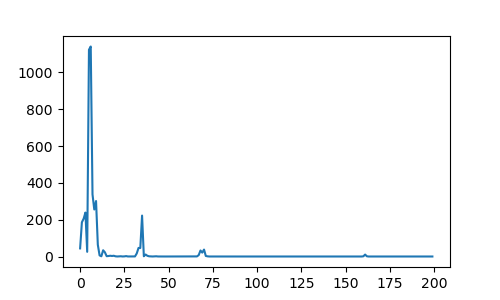

Final Loss:  0.0010566075596098717


In [14]:
# Plot the losses
plt.figure(figsize=(5, 3))
plt.plot(Losses)
plt.show()
print("Final Loss: ", Losses[-1])

In [16]:
X = torch.randn(10, 2)
y = torch.randint(0, 3, (10,))

print(X)
print(y)

tensor([[ 0.2459, -1.0006],
        [ 0.9705, -0.3086],
        [-0.7121, -0.2642],
        [-0.5208, -1.3792],
        [ 0.0193,  0.2751],
        [-2.8105, -0.2171],
        [-1.1804,  0.5191],
        [ 1.3419,  1.3906],
        [ 0.4534, -0.4561],
        [ 0.5184,  0.0634]])
tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 2])
